In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

In [2]:
tf.random.set_seed(0)

# Check the heuristics to select nosie variance

In [3]:
from src.ksd.kernel import median_heuristic, l2norm
from src.ksd.models import create_mixture_gaussian

In [4]:
dim = 5
n = 500

# Oracle choice of variance

In [228]:
ratio_target = 0.5
ratio_sample = 1.0

In [229]:
delta = 4.
target = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)
target_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)

samples_on = target.sample(n)
samples_off = target_off.sample(n)

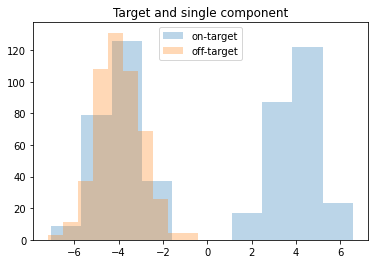

In [230]:
_ = plt.hist(samples_on.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component")

In [231]:
var = 5.
convolution = tfd.MultivariateNormalDiag(0., tf.math.sqrt(var) * tf.ones(dim))
samples_on_convolved = samples_on + convolution.sample(n)
samples_off_convolved = samples_off + convolution.sample(n)

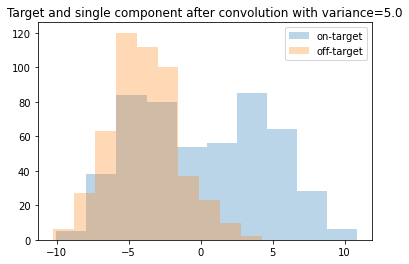

In [232]:
_ = plt.hist(samples_on_convolved.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(samples_off_convolved.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title(f"Target and single component after convolution with variance={var}")

## Convolved KSD as a function of log std

In [61]:
from src.ksd.ksd import ConvolvedKSD
tf.random.set_seed(0)

In [62]:
ratio_target = 0.5
ratio_sample = 1.0

In [63]:
delta = 6.
dim = 5
n = 500
num_est = 10000

target, target_log_prob = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target, return_logprob=True)
proposal_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)

convolution = tfd.MultivariateNormalDiag(0., tf.ones(dim))

kernel = IMQ(med_heuristic=True)

ksd = ConvolvedKSD(target=target, kernel=kernel, conv_kernel=None)

std_list = [tf.math.pow(2., x) for x in tf.experimental.numpy.arange(-10., 10., 1.0).numpy()]

In [64]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

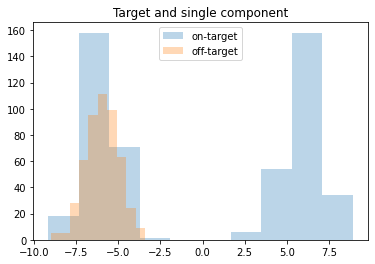

In [65]:
_ = plt.hist(on_sample.numpy()[:, 0], label="on-target", alpha=0.3)
_ = plt.hist(off_sample.numpy()[:, 0], label="off-target", alpha=0.3)
_ = plt.legend()
_ = plt.title("Target and single component")

In [59]:
ksd_df = pd.DataFrame(columns=["n", "ksd", "std", "seed", "type"])

for std in tqdm(std_list):
    for seed in range(10):
            # convolution sample
            conv_sample_full = convolution.sample(num_est) # for p

            conv_ind = tf.experimental.numpy.random.randint(low=0, high=num_est, size=n)
            conv_sample = tf.gather(conv_sample_full, conv_ind, axis=0) # for q

#             # off-target sample
#             off_sample = proposal_off.sample(n)

            log_noise_std = tf.math.log(std)

            ksd_val_off = ksd.eval(log_noise_std=log_noise_std, X=off_sample, Y=tf.identity(off_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_off, np.exp(log_noise_std), seed, "off-target"]

#             # on-target sample
#             on_sample = proposal_on.sample(n)

            log_noise_std_on = log_noise_std
            ksd_val_on = ksd.eval(log_noise_std=log_noise_std_on, X=on_sample, Y=tf.identity(on_sample), conv_samples_full=conv_sample_full, conv_samples=conv_sample).numpy()
            ksd_df.loc[len(ksd_df)] = [n, ksd_val_on, np.exp(log_noise_std_on), seed, "target"]


  0%|          | 0/20 [00:00<?, ?it/s]

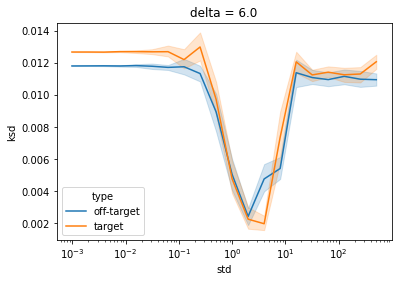

In [60]:
sns.lineplot(data=ksd_df, x="std", y="ksd", hue="type")
plt.xscale("log")
_ = plt.title(f"delta = {delta}")

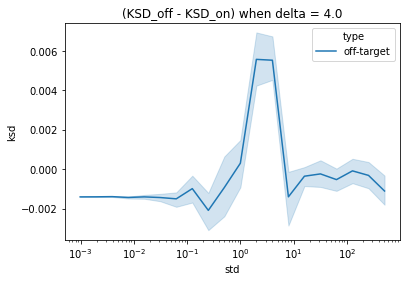

In [253]:
ksd_diff_df = ksd_df.loc[ksd_df.type == "off-target", ].copy()
ksd_diff_df["ksd"] = ksd_diff_df["ksd"].to_numpy() - ksd_df.loc[ksd_df.type == "target", "ksd"].to_numpy()

sns.lineplot(data=ksd_diff_df, x="std", y="ksd", hue="type")
plt.xscale("log")
_ = plt.title(f"(KSD_off - KSD_on) when delta = {delta}")

# MH approach

In [24]:
from src.ksd.langevin import RandomWalkMH
tf.random.set_seed(0)

In [25]:
ratio_target = 0.3
ratio_sample = 1.

In [26]:
delta = 4.
dim = 5
n = 500
num_est = 10000

target, target_log_prob = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target, return_logprob=True)
proposal_off = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_sample)
proposal_on = create_mixture_gaussian(dim=dim, delta=delta, ratio=ratio_target)

In [27]:
# off-target sample
off_sample = proposal_off.sample(n)

# on-target sample
on_sample = proposal_on.sample(n)

In [28]:
steps = 20
std = 10.
x_init_off = tf.identity(off_sample)

mh_off = RandomWalkMH(log_prob=target_log_prob)
mh_off.run(steps=steps, std=std, x_init=x_init_off, verbose=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.88it/s]


In [29]:
# check if the hard-coded log_prob equals to the built-in fn
diff = target_log_prob(x_init_off) - target.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [30]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = int(np.sqrt(nplots))
    ncols = int(np.ceil(nplots / nrows))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_sample.numpy()[:, 0], bins=20, label="target", alpha=0.4)
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

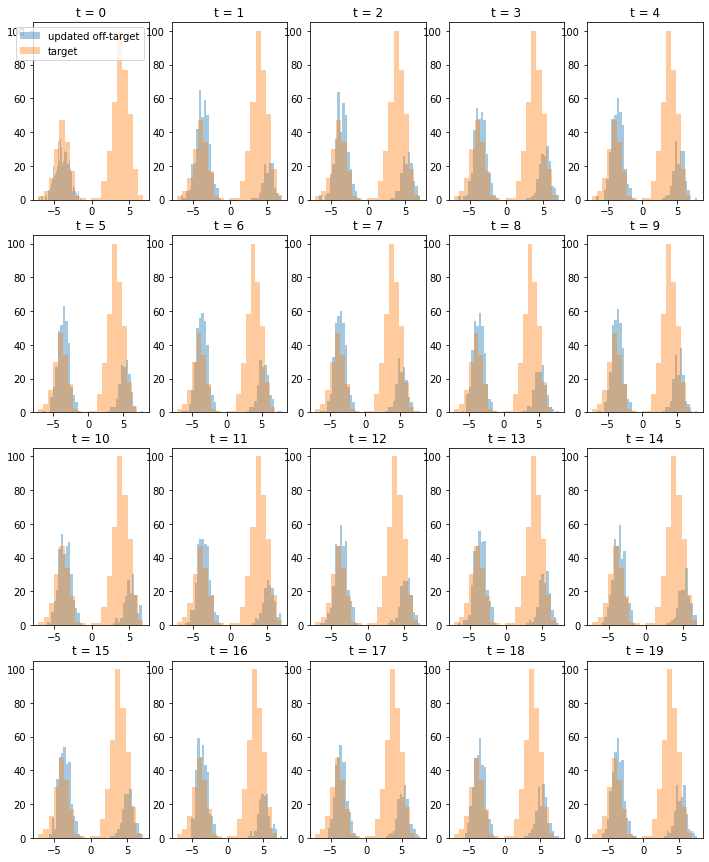

In [31]:
plot_t_step = 1 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mh_off)

In [32]:
mh_on = RandomWalkMH(log_prob=target_log_prob)

x_init_on = tf.identity(on_sample)
mh_on.run(steps=steps, std=std, x_init=x_init_on)

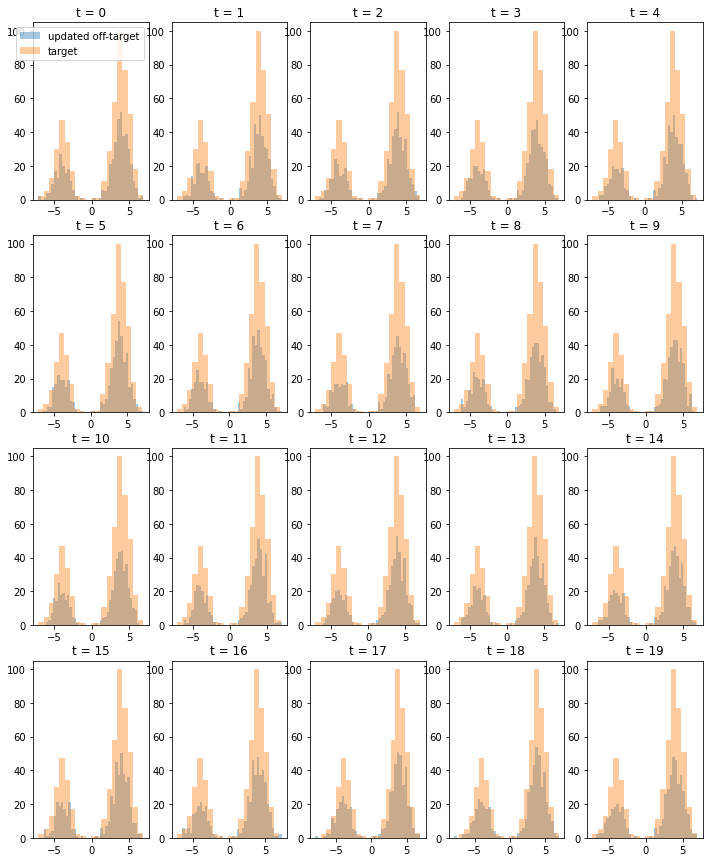

In [33]:
plot_steps(plot_t_step=plot_t_step, result=mh_on)

# KSD as a function of number of step

In [34]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 5

In [35]:
def run_mh_experiment(nrep, proposal_off, proposal_on, steps, std):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mh_off = RandomWalkMH(log_prob=target_log_prob)
        mh_off.run(steps=steps, std=std, x_init=x_init_off)

        mh_on = RandomWalkMH(log_prob=target_log_prob)
        mh_on.run(steps=steps, std=std, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mh_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mh_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [36]:
nsteps=20
std=10.

ksd_df = run_mh_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std=std)

  0%|          | 0/5 [00:00<?, ?it/s]

<AxesSubplot:xlabel='t', ylabel='ksd'>

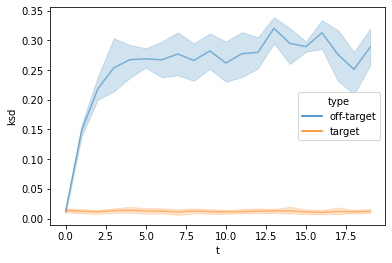

In [37]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)